<a href="https://colab.research.google.com/github/joshuacheng28/Advanced-artificial-intelligence/blob/main/HomeWork_12_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
import zipfile

#import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import optimizers

#callback
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

#model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


In [ ]:

zip_ref = zipfile.ZipFile('/content/chest_xray.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
rootdir = '/content/chest_xray'
train_dir = os.path.join(rootdir,'train')
val_dir   = os.path.join(rootdir,'val')

In [ ]:
dataset = []
for root, dirs, files in os.walk(train_dir):
  for file in files:
    if(file.lower().endswith(".jpeg")):
      dataset.append((os.path.join(root, file),root.split('/')[-1]))

for root, dirs, files in os.walk(val_dir):
  for file in files:
    if(file.lower().endswith(".jpeg")):
      dataset.append((os.path.join(root, file),root.split('/')[-1]))

dataset = pd.DataFrame(dataset, columns = ('filename','label'))
dataset = shuffle(dataset)
dataset['label'].value_counts()

msk = np.random.rand(len(dataset)) < 0.8
train_data = dataset[msk]
val_data = dataset[~msk]
# data generation for Keras
train_datagen=ImageDataGenerator(rescale = 1./255,
                                 vertical_flip=True)
target_size = (224,224)

rootPath = "./"
batch = 32
train_generator = train_datagen.flow_from_dataframe(dataframe=train_data, directory=rootPath , x_col="filename",y_col="label",class_mode="categorical",target_size=target_size,batch_size=batch)
val_generator = train_datagen.flow_from_dataframe(dataframe=train_data, directory=rootPath , x_col="filename",y_col="label",class_mode="categorical",target_size=target_size,batch_size=batch)


Found 4154 validated image filenames belonging to 2 classes.
Found 4154 validated image filenames belonging to 2 classes.


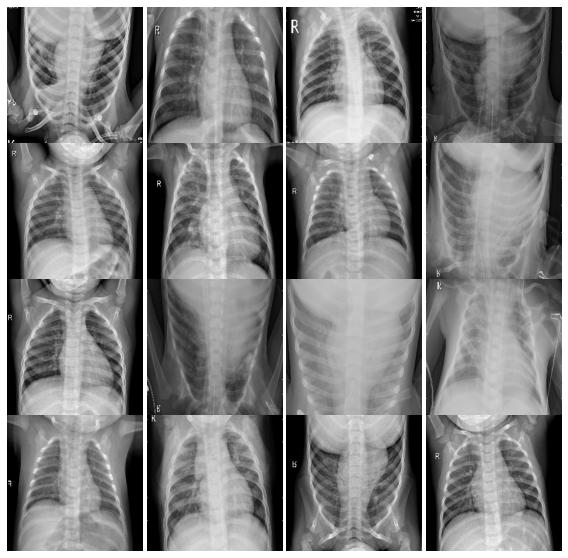

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0,10.0)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(16):
  x,y = train_generator.next()
  img = x[0,:,:,:]
  plt.subplot(4,4, i+1)
  plt.imshow(img,cmap='gray'); plt.axis('off')

In [ ]:
base_model = DenseNet121(input_shape=(*target_size , 3),include_top=False , weights='imagenet')
# add a global spatial average pooling layer

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

#add a logistic layer -- we have 2 classes
predictions = Dense(2, activation='sigmoid')(x)

#print(predicitions)
model = Model(inputs=base_model.input, outputs=predictions)
#model.summary()

29097984/29084464 [==============================] - 1s 0us/step


In [ ]:
from sklearn.utils.class_weight import compute_class_weight,compute_sample_weight
title = ['PNEUMONIA','NORMAL']
labels_count = train_data['label'].value_counts()

weight = np.zeros(len(title))
class_sum = 0
for name in title:
  class_sum += labels_count[name]
  weight_idx = train_generator.class_indices[name]
  weight[weight_idx] = 1/(len(title)*labels_count[name])

weight = weight * class_sum
weight = {i:weight[i] for i in range(2)}
print(weight)



{0: 1.9465791940018744, 1: 0.6728215095562035}


In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr * epoch / 5 + 0.00001
  elif epoch < 10:
    return lr
  else:
    return lr * np.exp(-0.1)

checkpoint_filepath = '/content/tmp/checkpoint.h5'
if(not os.path.isdir('/content/tmp')):
  os.mkdir('/content/tmp')

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
METRICE = [
           'binary_accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
]
adam = optimizers.Adam(lr = 0.01,decay=0.00001)
model.compile(optimizer = adam, loss = 'binary_crossentropy',metrics=METRICE)

epochs = 10
history = model.fit(train_generator,
                    validation_data=val_generator,
                    class_weight = weight,
                    callbacks=[LearningRateScheduler(scheduler),model_checkpoint_callback],
                    epochs=epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
130/130 [==============================] - 194s 1s/step - loss: 0.5237 - binary_accuracy: 0.7718 - precision: 0.7522 - recall: 0.8105 - val_loss: 0.4951 - val_binary_accuracy: 0.7506 - val_precision: 0.7463 - val_recall: 0.7593 - lr: 1.0000e-05
Epoch 2/10
130/130 [==============================] - 167s 1s/step - loss: 0.3030 - binary_accuracy: 0.8881 - precision: 0.8873 - recall: 0.8890 - val_loss: 0.5495 - val_binary_accuracy: 0.7498 - val_precision: 0.7479 - val_recall: 0.7535 - lr: 1.2000e-05
Epoch 3/10
130/130 [==============================] - 153s 1s/step - loss: 0.2112 - binary_accuracy: 0.9322 - precision: 0.9311 - recall: 0.9336 - val_loss: 0.5705 - val_binary_accuracy: 0.7628 - val_precision: 0.7568 - val_recall: 0.7744 - lr: 1.4800e-05
Epoch 4/10
130/130 [==============================] - 153s 1s/step - loss: 0.1486 - binary_accuracy: 0.9550 - precision: 0.9537 - recall: 0.9564 - val_loss: 0.3713 - val_binary_accuracy: 0.8380 - val_precision: 0.8220 - val_recall: 

In [ ]:
test_dir = os.path.join(rootdir, 'test')
testDataset = []
for root, dirs, files in os.walk(test_dir):
  for file in files:
    if(file.lower().endswith(".jpeg")):
      testDataset.append((os.path.join(root,file), root.split('/')[-1]))
testDataset = pd.DataFrame(testDataset, columns = ('filename','label'))
testDataset = shuffle(testDataset)
testDataset['label'].value_counts()

test_datagen=ImageDataGenerator(rescale=1./255)#rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=testDataset,directory=rootPath , x_col='filename', y_col="label", class_model="categorical", target_size=target_size, batch_size=1, shuffle =False)

test_generator.reset()
y_pred_keras = model.predict_generator(test_generator,verbose=1,steps=test_generator.n)
loss,acc,pre,recall = model.evaluate_generator(test_generator,steps=test_generator.n,verbose=1)
print(loss,acc)

y_pred_label = []
for y_pred in y_pred_keras:
  y_pred_labels.append(np.argmax(y_pred))

y_labels = test_generator.labels


NameError: ignored

SyntaxError: ignored

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_ladels, y_pred_labels)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()
plt.figure(1, figsize=(12,10))
plt.plot([0,1],[0, 1], 'k--')
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels, y_pred_labels)
auc_keras = aud(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras,label= title[]t '(area=(:.3f))'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall =tp/(tp+fn)
accuracy= (tpttn)/(tntfptfn+tp)
print("Recall of the model is f:.2f)".format(recall))
print("precision of the model is (:.2f)".format(precision))
print("Accuracy of the model is f(:.2f)".format(accuracy))

In [ ]:
pretrain_model = tf.keras.models.load_model('/content/bestmodel 224.h5')
#pretrain_model.summary()
print(pretrain_model.layers[-5])
x = pretrain_model.layers[-5].output
x = GlobalAveragepooling2D()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- we have 2 classes
predictions = Dense(2, activation='sigmoid')(x)
#print(predictions)
model = Model(inputs=pretrain_model.input, outputs=predictions)
#model.summary()

In [ ]:
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = METRICS)
epochs = 10
history = model.fit(train_generator,
validation data=val generator,
class_weight = weight,
#callbacks=[LearningRatescheduler(scheduler),model_checkpoint_callback],
epochs=epochs)